In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.utils.dynamical_systems import Lorenz63, Lorenz96
import adjoint_esn.utils.solve_ode as solve_ode
from adjoint_esn.utils import preprocessing as pp
from adjoint_esn.utils import errors
import adjoint_esn.utils.lyapunov as lyap
from adjoint_esn.utils import visualizations as vis
from adjoint_esn.esn import ESN
from adjoint_esn.validation import set_ESN
from adjoint_esn.utils import errors,scalers
from adjoint_esn.validation import validate
from adjoint_esn.validation import set_ESN
import yaml
from pathlib import Path


In [19]:
def load_config(experiment_path):
       with open(experiment_path/'config.yml', 'r') as file:
         config = yaml.unsafe_load(file)
         return config

experiment_path=Path('../local_results/lorenz63/run_20240105_140530') 
sys = Lorenz63
config = load_config(experiment_path)
results = pp.unpickle_file(experiment_path / 'results.pickle')[0]
print(config)
print(results)

model:
  connectivity: 3
  input_only_mode: false
  input_vars:
  - x
  - y
  - z
  input_weights_mode: sparse_grouped
  network_dt: 0.01
  param_vars:
  - beta
  - rho
  - sigma
  r2_mode: false
  reservoir_size: 1800
  reservoir_weights_mode: erdos_renyi1
  washout_time: 4
random_seed: 41
simulation:
  beta_list:
  - 1
  - 1.5
  - 2
  - 2.5
  - 3
  integrator: rk4
  noise_level: 0
  rho_list:
  - 30
  - 35
  - 40
  - 45
  - 50
  sigma_list:
  - 8
  - 10
  - 12
  - 14
  - 16
  sim_dt: 0.01
  sim_time: 200
  transient_time: 20
train:
  regime_selection: 20
  tikhonov: 0.001
  time: 10
val:
  error_measure: rel_L2
  fold_time: 2
  hyperparameters:
    input_scaling:
      max: 1.0
      min: 0.001
      scale: log10
    leak_factor:
      max: 1.0
      min: 0.1
      scale: uniform
    parameter_normalization_mean:
      beta:
        max: 2.0
        min: -2.0
        scale: uniform
      rho:
        max: 40.0
        min: -40.0
        scale: uniform
      sigma:
        max: 12.0
 

## Generate data

In [20]:
try:
    integrator = config.simulation.integrator
except:
    integrator = 'odeint'

# simulation options
sim_time = config.simulation.sim_time
sim_dt = config.simulation.sim_dt

# directory to search for simulation data, if the data doesn't exist, 
# then it will simulate the system
data_dir=Path('..\data')

# which regimes to use for training and validation
train_param_list = results["training_parameters"]

train_idx_list = np.arange(len(train_param_list))

transient_time = config.simulation.transient_time

noise_level = config.simulation.noise_level
random_seed = config.random_seed

# network time step
network_dt = config.model.network_dt

washout_time = config.model.washout_time

# which states to use as input and output
# for standard ESN these should be the same, e.g. both 'eta_mu'
# for Rijke ESN, input and output should be 'eta_mu_v_tau' and 'eta_mu' respectively
input_vars = config.model.input_vars

# which system parameter is passed to the ESN
param_vars=config.model.param_vars

# length of training time series
train_time = config.train.time

loop_names=['train']
loop_times = [train_time]

eParam = sys.get_eParamVar()
DATA = {}
for loop_name in loop_names:
    DATA[loop_name]={'u_washout':[],'p_washout':[],'u':[],'p':[],'y':[],'t':[]}

for p_idx, p in enumerate(train_param_list):
    regime_str = ' '.join([f"{param.name} = {p[param]:0.3f}" for param in sys.get_eParamVar()])
    print("Regime:", regime_str)
    params = {}
    for param in eParam:
        params[param.name] = p[param]
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(sys,
                                                params,
                                                sim_time,
                                                sim_dt,
                                                random_seed=random_seed,
                                                integrator=integrator)

    regime_data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=config.model.input_vars,
                        param_vars=config.model.param_vars,
                        loop_times=loop_times,
                        loop_names=loop_names)
    
    for loop_name in loop_names:
        [DATA[loop_name][var].append(regime_data[loop_name][var]) for var in DATA[loop_name].keys()]

# dimension of the inputs
dim = DATA["train"]["u"][0].shape[1]

Regime: beta = 1.500 rho = 30.000 sigma = 8.000
Regime: beta = 1.500 rho = 40.000 sigma = 12.000
Regime: beta = 2.500 rho = 30.000 sigma = 16.000
Regime: beta = 3.000 rho = 40.000 sigma = 10.000
Regime: beta = 1.500 rho = 45.000 sigma = 14.000
Regime: beta = 1.000 rho = 40.000 sigma = 16.000
Regime: beta = 1.500 rho = 35.000 sigma = 12.000
Regime: beta = 2.000 rho = 40.000 sigma = 14.000
Regime: beta = 2.000 rho = 35.000 sigma = 12.000
Regime: beta = 2.500 rho = 35.000 sigma = 14.000
Regime: beta = 3.000 rho = 35.000 sigma = 8.000
Regime: beta = 2.500 rho = 50.000 sigma = 12.000
Regime: beta = 3.000 rho = 50.000 sigma = 8.000
Regime: beta = 2.500 rho = 35.000 sigma = 12.000
Regime: beta = 3.000 rho = 35.000 sigma = 10.000
Regime: beta = 2.500 rho = 45.000 sigma = 16.000
Regime: beta = 3.000 rho = 40.000 sigma = 8.000
Regime: beta = 3.000 rho = 45.000 sigma = 10.000
Regime: beta = 1.000 rho = 35.000 sigma = 10.000
Regime: beta = 1.000 rho = 35.000 sigma = 16.000


### Plot data

In [ ]:
len_p_list=len(train_param_list)
plt_idx = [0,1,2]
plt_idx_pairs = [[0,1],
                 [0,2]]
for p_idx, p in enumerate(train_param_list):
    plt.figure(figsize = (15,3),constrained_layout=True)
    for j, k in enumerate(plt_idx):
        plt.subplot(1,len(plt_idx),j+1)
        title_str = ' '.join([f"{param.name} = {p[param]:0.3f}" for param in eParam])
        vis.plot_lines(DATA["train"]["t"][p_idx],DATA["train"]["u"][p_idx][:,k],
                   title=title_str,
                   xlabel='t')
        # plt.xlim([washout_time,20+washout_time])

    plt.figure(figsize = (15,3),constrained_layout=True)
    for j, k in enumerate(plt_idx_pairs):
        plt.subplot(1,len(plt_idx),j+1)
        vis.plot_phase_space(DATA["train"]["u"][p_idx],
                            idx_pair=k,
                            title=title_str)

## Train 

In [21]:
res_idx = 0
ESN_dict = {
        "reservoir_size": config.model.reservoir_size,
        "parameter_dimension": len(param_vars),
        "reservoir_connectivity": config.model.connectivity,
        "r2_mode": config.model.r2_mode,
        "input_only_mode": config.model.input_only_mode,
        "input_weights_mode": config.model.input_weights_mode,
        "reservoir_weights_mode": config.model.reservoir_weights_mode,
        "tikhonov": config.train.tikhonov,
        "dimension": dim,
    }
print('System dimension: ', dim)

hyp_param_names = []
hyp_params = []
for name in results.keys():
    if name not in ['training_parameters','validation_parameters','f','tikh']:
        if results[name].ndim == 2:
            hyp_param_names.extend([name]*results[name].shape[1])
            hyp_params.extend(results[name][res_idx])
        elif results[name].ndim == 1:
            hyp_param_names.extend([name])
            hyp_params.extend([results[name][res_idx]])
        
hyp_param_scales = ['uniform']*len(hyp_param_names)

ESN_dict['input_seeds'] = [5,6,7]
ESN_dict['reservoir_seeds'] = [8,9]

my_ESN = ESN(**ESN_dict)
set_ESN(my_ESN,hyp_param_names,hyp_param_scales,hyp_params)

my_ESN.train(DATA["train"]["u_washout"], 
             DATA["train"]["u"], 
             DATA["train"]["y"],
             P_washout=DATA["train"]["p_washout"], 
             P_train=DATA["train"]["p"],
             train_idx_list=train_idx_list)

System dimension:  3
Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.
Parameter normalization is changed, training must be done again.
Reservoir weights are rescaled with the new spectral radius.
Input weights are rescaled with the new input scaling.
Parameter normalization is changed, training must be done again.


In [34]:
y0 = np.zeros((1,DATA["train"]["u_washout"][0].shape[1]))
y0[0,:] = [7.432487609628195, 10.02071718705213, 29.62297428638419]
# y0[0,:] = [1,1,1]
u_washout_auto = np.repeat(y0, [len(DATA["train"]["u_washout"][0])], axis = 0)

In [38]:
def Lyapunov_Time(sys, params):
    loop_times = [200]
    sim_time = loop_times[0] + transient_time + 10
    loop_names = ["test"]
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(sys,
                                                params,
                                                sim_time,
                                                sim_dt,
                                                random_seed=0,
                                                integrator=integrator)
    input_vars = [f"{input_var.name}" for input_var in my_sys.get_eVar()]
    param_vars = [f"{param_var.name}" for param_var in my_sys.get_eParamVar()]
    data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=0,
                        input_vars=input_vars,
                        param_vars=param_vars,
                        loop_times=loop_times,
                        loop_names=loop_names)

    LEs, FTLE, QQ, RR = lyap.calculate_LEs(sys=my_sys,
                                    sys_type='continuous',
                                    X=data["test"]["u"],
                                    t=data["test"]["t"],
                                    transient_time=transient_time,
                                    dt=network_dt,
                                    target_dim=None,
                                    norm_step=1)
    LEs_target = LEs[-1]
    print('Lyapunov exponents:', LEs_target)
    LT = 1/LEs_target[0]
    print('Lyapunov time:', LT)
    if LT <= 0:
        return 1
    else:
        return LT

## Predict and visualize

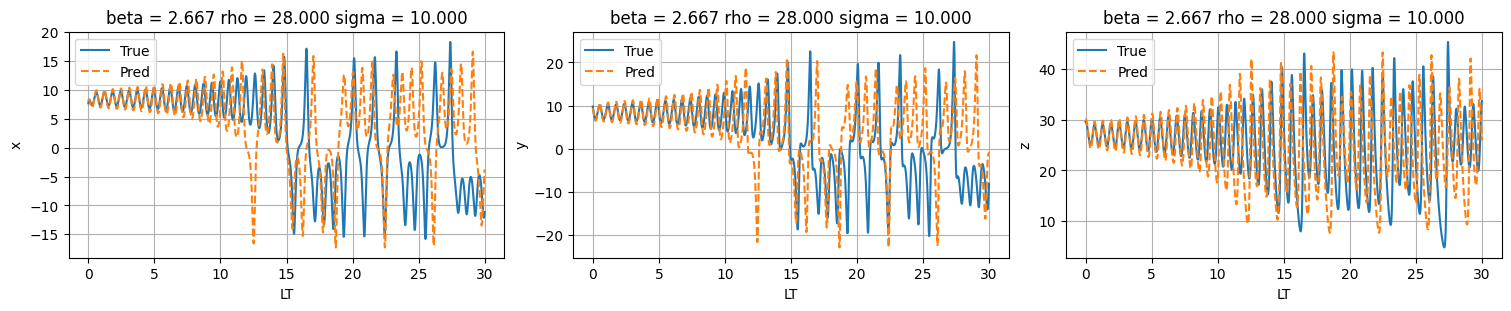

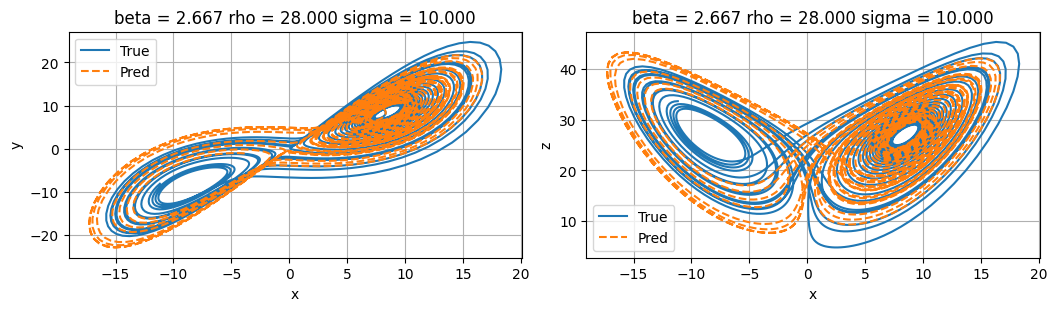

In [35]:
loop_times = [30]
sim_time = loop_times[0] + transient_time + 10

if sys == Lorenz63:
    param_mesh_input = [None] * 3
    param_mesh_input[eParam.beta] = [2.667]
    param_mesh_input[eParam.rho] = [28.0]
    param_mesh_input[eParam.sigma] = [10.0]
    eVars = my_sys.get_eVar()
    plt_idx = [eVars.x, eVars.y, eVars.z]
    plt_idx_pairs = [[eVars.x, eVars.y],
                    [eVars.x,eVars.z],]
elif sys == Lorenz96:
    param_mesh_input = [None] * 1
    param_mesh_input[eParam.p] = np.arange(5,10,1)
    eVars = my_sys.get_eVar()
    plt_idx = [eVars.x1, eVars.x2, eVars.x3]
    plt_idx_pairs = [[eVars.x1, eVars.x2],
                    [eVars.x1,eVars.x3],]

p_list = pp.make_param_mesh(param_mesh_input)

phase_space_steps = pp.get_steps(30,network_dt)

error_measure = errors.rel_L2

for p_idx, p in enumerate(p_list):
    params = {}
    for param in eParam:
        params[param.name] = p[param]
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(sys,
                                                params,
                                                sim_time,
                                                sim_dt,
                                                # random_seed=1,
                                                y_init=y0[0],
                                                integrator=integrator)

    data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=0,#transient_time,
                        washout_time=0,
                        input_vars=config.model.input_vars,
                        param_vars=config.model.param_vars,
                        loop_times=loop_times,
                        loop_names=loop_names)
    
    # LT = Lyapunov_Time(sys, params)
    LT = 1
    for loop_name in data.keys():
        param0 = np.array([data[loop_name]["p"][0,:]])
        p_washout_auto = np.repeat(param0, [len(DATA["train"]["u_washout"][0])], axis = 0)
        _, y_pred = my_ESN.closed_loop_with_washout(U_washout=u_washout_auto, #data[loop_name]["u_washout"], 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=p_washout_auto, #data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])
        y_pred = y_pred[1:]

        regime_str = ' '.join([f"{param.name} = {p[param]:0.3f}" for param in eParam])
        # plot time series
        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx):
            plt.subplot(1,len(plt_idx),j+1)
            t = (data[loop_name]["t"]-data[loop_name]["t"][0])/LT
            vis.plot_lines(t,data[loop_name]["y"][:,k],y_pred[:,k],
                       title=regime_str,
                       xlabel='LT',
                       ylabel=k.name,
                       linestyle=['-','--'],
                       legend=['True','Pred'])
            
        # plot phase space  
        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx_pairs):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_phase_space(data[loop_name]["y"][-phase_space_steps:],
                             y_pred[-phase_space_steps:],
                             idx_pair=k,
                             xlabel=k[0].name,
                             ylabel=k[1].name,
                             title=regime_str,
                             linestyle=['-','--'],
                             legend=['True','Pred'])

        # plot statistics    
        # plt.figure(figsize = (15,3),constrained_layout=True)
        # for j, k in enumerate(plt_idx):
        #     plt.subplot(1,len(plt_idx),j+1)
        #     vis.plot_statistics(data[loop_name]["y"][:,k],y_pred[:,k],
        #                         title=regime_str,
        #                         ylabel='PDF',
        #                         linestyle=['-','--'],
        #                         legend=['True','Pred'])
        # plt.figure(figsize = (15,3),constrained_layout=True)

## Statistics

In [40]:
# generate and train ESN realisations
n_ensemble = 5
res_idx = 0
ESN_list = [None] * n_ensemble
for e_idx in range(n_ensemble):
    # fix the seeds
    input_seeds = [5 * e_idx, 5 * e_idx + 1, 5 * e_idx + 2]
    reservoir_seeds = [5 * e_idx + 3, 5 * e_idx + 4]

    # expand the ESN dict with the fixed seeds
    ESN_dict["input_seeds"] = input_seeds
    ESN_dict["reservoir_seeds"] = reservoir_seeds
    ESN_dict["verbose"] = False
    my_ESN = ESN(**ESN_dict)
    set_ESN(my_ESN,hyp_param_names,hyp_param_scales,hyp_params)

    my_ESN.train(DATA["train"]["u_washout"], 
                DATA["train"]["u"], 
                DATA["train"]["y"],
                P_washout=DATA["train"]["p_washout"], 
                P_train=DATA["train"]["p"],
                train_idx_list=train_idx_list)
    ESN_list[e_idx] = my_ESN

Running solver.


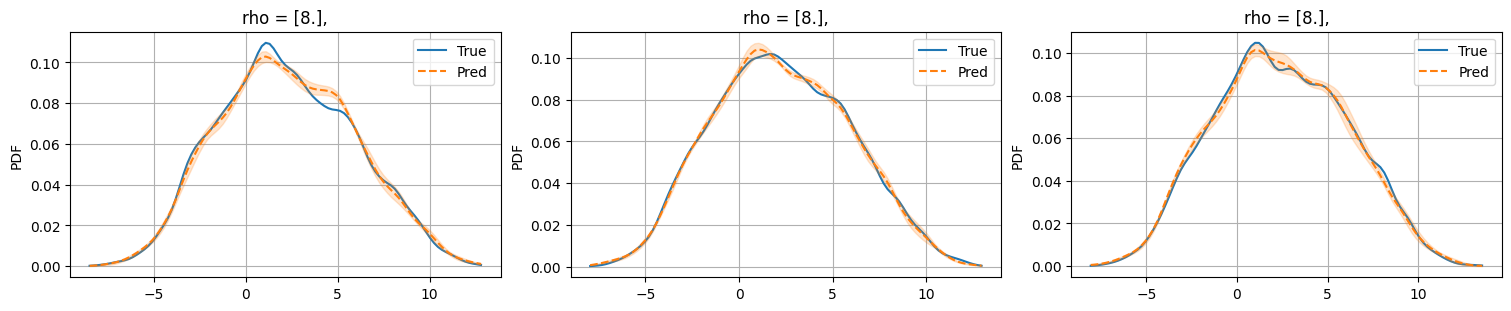

In [49]:
LT =  0.91585
loop_times = [LT*1000]
sim_time = loop_times[0] + transient_time + 10

if sys == Lorenz63:
    param_mesh_input = [None] * 3
    param_mesh_input[eParam.beta] = [1.75]
    param_mesh_input[eParam.rho] = [52.0]
    param_mesh_input[eParam.sigma] = [13.0]
    eVars = my_sys.get_eVar()
    plt_idx = [eVars.x, eVars.y, eVars.z]
elif sys == Lorenz96:
    param_mesh_input = [None] * 1
    param_mesh_input[eParam.p] = [8.0]

p_list = pp.make_param_mesh(param_mesh_input)

for p_idx, p in enumerate(p_list):
    params = {}
    for param in eParam:
        params[param.name] = p[param]
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(sys,
                                                params,
                                                sim_time,
                                                sim_dt,
                                                # y_init=y0[0],
                                                random_seed=0,
                                                integrator=integrator)

    data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=config.model.input_vars,
                        param_vars=config.model.param_vars,
                        loop_times=loop_times)
    
    for loop_name in data.keys():
        Y_PRED = [None] * n_ensemble
        for e_idx, my_ESN in enumerate(ESN_list):
            param0 = np.array([data[loop_name]["p"][0,:]])
            p_washout_auto = np.repeat(param0, [len(DATA["train"]["u_washout"][0])], axis = 0)
            _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                        N_t=len(data[loop_name]["u"]), 
                                                        P_washout=data[loop_name]["p_washout"],  
                                                        P=data[loop_name]["p"])
            y_pred = y_pred[1:]
            Y_PRED[e_idx] = y_pred
            regime_str = f'rho = {p},'

        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_statistics_ensemble(*[Y_PRED[e][:, k] for e in range(n_ensemble)],
                                y_base=data[loop_name]["y"][:,k],
                                title=regime_str,
                                ylabel='PDF',
                                linestyle=['-','--'],
                                legend=['True','Pred'],
                                color=["tab:blue","tab:orange"])

In [54]:
def objective_fun(u):
    return np.mean(u[:,2])

loop_times = [1000]
sim_time = loop_times[0] + transient_time + 10

if sys == Lorenz63:
    param_mesh_input = [None] * 3
    param_mesh_input[eParam.beta] = np.arange(0.5,3.0,0.1)
    param_mesh_input[eParam.rho] = [28]
    param_mesh_input[eParam.sigma] = [10] #np.arange(6,23,1) 
elif sys == Lorenz96:
    param_mesh_input = [None] * 1
    param_mesh_input[eParam.p] = np.arange(5,11,0.5)

p_list = pp.make_param_mesh(param_mesh_input)

obj_bar = np.zeros(len(p_list))
obj_bar_pred = np.zeros(len(p_list))

for p_idx, p in enumerate(p_list):
    params = {}
    for param in eParam:
        params[param.name] = p[param]
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(sys,
                                                params,
                                                sim_time,
                                                sim_dt,
                                                random_seed=0,
                                                integrator=integrator)

    data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=config.model.input_vars,
                        param_vars=config.model.param_vars,
                        loop_times=loop_times,
                        )
    obj_bar[p_idx] = objective_fun(data["loop_0"]["y"])
    for loop_name in data.keys():
        _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])
        y_pred = y_pred[1:]

    obj_bar_pred[p_idx] = objective_fun(y_pred)

Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.


In [55]:
def plot_obj_and_grad(eParam_name, degree = 2):
    coeffs = np.polyfit(p_list[:,eParam_name],obj_bar, deg = degree)
    vals = np.polyval(coeffs, p_list[:,eParam_name])
    coeffs_pred = np.polyfit(p_list[:,eParam_name],obj_bar_pred, deg = degree)
    vals_pred = np.polyval(coeffs_pred, p_list[:,eParam_name])


    plt.figure(figsize=(15,3))

    plt.subplot(1,3,1)
    plt.plot(p_list[:,eParam_name],obj_bar,'-o',linewidth=4)
    plt.plot(p_list[:,eParam_name],obj_bar_pred, '--+', color="tab:orange",linewidth=2)
    plt.xlabel(eParam_name.name)
    plt.ylabel("z_bar")
    plt.legend(["True","ESN"])
    plt.grid()

    plt.subplot(1,3,2)
    plt.plot(p_list[:,eParam_name],vals,'-o',linewidth=4)
    plt.plot(p_list[:,eParam_name],vals_pred, '--+', color="tab:orange",linewidth=2)
    plt.xlabel(eParam_name.name)
    plt.ylabel("z_bar")
    plt.legend(["True","ESN"])
    plt.title(f"Degree {degree} polynomial approx")
    plt.grid()

    plt.subplot(1,3,3)
    spacing = p_list[:,eParam_name][1]-p_list[:,eParam_name][0]
    grads = np.gradient(vals,spacing)
    grads_pred = np.gradient(vals_pred,spacing)
    plt.plot(p_list[:,eParam_name],grads,'-o',linewidth=4)
    plt.plot(p_list[:,eParam_name],grads_pred, '--+', color="tab:orange",linewidth=2)
    plt.xlabel(eParam_name.name)
    plt.ylabel(f"dz_bar/d{eParam_name.name}")
    plt.legend(["True","ESN"])
    plt.grid()

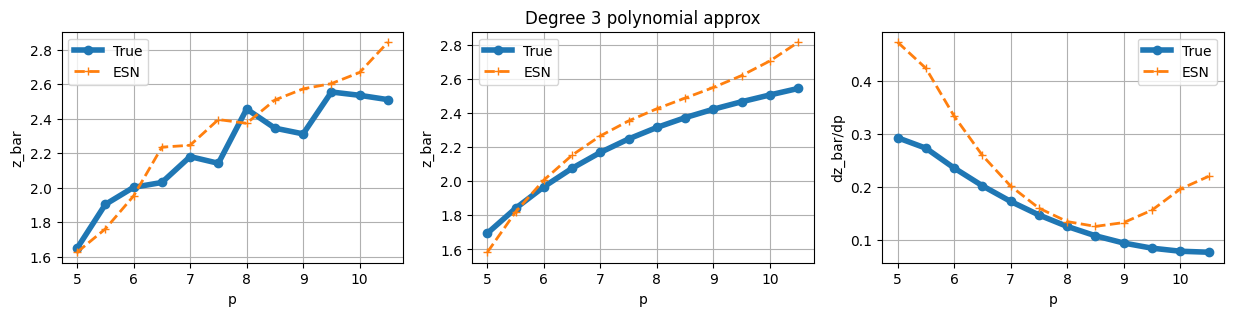

In [56]:
plot_obj_and_grad(eParam.p, degree = 3)

## Lyapunov stability analysis

In [43]:
params = {"beta": 1.75,
          "rho": 52.0,
          "sigma": 13.0}

sim_time = 224
loop_times = [200]
loop_names = ["test"]
my_sys, y_sim, t_sim = pp.load_data_dyn_sys(Lorenz63,
                                            params,
                                            sim_time,
                                            sim_dt,
                                            random_seed=0,
                                            integrator=integrator)

data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                    network_dt=network_dt,
                    transient_time=transient_time,
                    washout_time=washout_time,
                    input_vars=["x","y","z"],
                    param_vars=["beta","rho","sigma"],
                    loop_times=loop_times,
                    loop_names=loop_names)

LEs, FTLE, QQ, RR = lyap.calculate_LEs(sys=my_sys,
                                 sys_type='continuous',
                                 X=data["test"]["u"],
                                 t=data["test"]["t"],
                                 transient_time=transient_time,
                                 dt=network_dt,
                                 target_dim=None,
                                 norm_step=1)
LEs_target = LEs[-1]
print('Lyapunov exponents:', LEs_target)
print('Lyapunov time:', 1/LEs_target[0])
CLVs, angles, FTCLE = lyap.calculate_CLVs(QQ,RR,network_dt)

Running solver.
[ 1.17860319e+00  9.00419475e-03 -1.69373465e+01]


In [ ]:
x_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=data["test"]["u_washout"], 
                                                        N_t=len(data["test"]["u"]), 
                                                        P_washout=data["test"]["p_washout"],  
                                                        P=data["test"]["p"])
y_pred = y_pred[1:]
LEs, FTLE, QQ, RR = lyap.calculate_LEs(sys=my_ESN,
                                 sys_type='ESN',
                                 X=x_pred,
                                 t=data["test"]["t"],
                                 transient_time=transient_time,
                                 dt=network_dt,
                                 target_dim=my_sys.N_dim,
                                 norm_step=1)
LEs_target = LEs[-1]
print(LEs_target)
CLVs, angles, FTCLE = lyap.calculate_CLVs(QQ,RR,network_dt)

## Sensitivity

In [4]:
from adjoint_esn.utils import dynamical_systems_sensitivity as sens

def objective_fun(u):
    return np.mean(u[:,2])

def dobjective_fun(u):
    dobj = np.zeros(len(u))
    dobj[2] = 1
    return dobj

# def objective_fun(u):
#     return np.mean(np.sum(u, axis=1))

# def dobjective_fun(u):
#     return np.array([1,1,1])

# def objective_fun(u):
#     return np.mean(np.sum(u**2, axis=1))

# def dobjective_fun(u):
#     return 2*u


In [23]:
if sys == Lorenz63:
    params = {}
    params["beta"] = 8/3
    params["rho"] = 28.0
    params["sigma"] = 10.0
elif sys == Lorenz96:
    params = {}
    params["p"] = 8.0

sim_time = 1.0
for random_seed in range(1):
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(sys,
                                                params,
                                                sim_time,
                                                sim_dt,
                                                random_seed=random_seed,
                                                integrator=integrator)

    dJdp_direct = sens.true_direct_sensitivity(my_sys, t_sim, y_sim, dobjective_fun,integrator=integrator)
    dJdp_adj = sens.true_adjoint_sensitivity(my_sys, t_sim, y_sim, dobjective_fun,integrator=integrator)
    dJdp_finite = sens.true_finite_difference_sensitivity(
        my_sys, t_sim, y_sim, h=1e-8, objective_fun=objective_fun, method="central",integrator=integrator)
    print('Direct', dJdp_direct)
    print('Adjoint', dJdp_adj)
    print('Finite', dJdp_finite)

Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Direct [-0.98474768  1.0932801   0.10018773]
Adjoint [-0.98474768  1.0932801   0.10018773]
Finite [-0.95895896  1.09470086  0.09954153]


In [ ]:
sim_time = 200
n_loops = 100
loop_times = [sim_time]
loop_time_arr = [2.0]
transient_time = 20.0
washout_time = 4.0

if sys == Lorenz63:
    param_mesh_input = [None] * 3
    param_mesh_input[eParam.beta] = [8/3]
    param_mesh_input[eParam.rho] = [28.0]
    param_mesh_input[eParam.sigma] = [10.0]
elif sys == Lorenz96:
    param_mesh_input = [None] * 1
    param_mesh_input[eParam.p] = [8.0]

p_list = pp.make_param_mesh(param_mesh_input)

methods = ['direct','adjoint','finite']
dJdp = {'true':{},'esn':{}}
for method_name in methods:
    dJdp['true'][method_name] = np.zeros((len(p_list),my_sys.N_param,n_loops,len(loop_time_arr)))
    dJdp['esn'][method_name] = np.zeros((len(p_list),len(param_vars),n_loops,len(loop_time_arr)))

for p_idx, p in enumerate(p_list):
    params = {}
    for param in eParam:
        params[param.name] = p[param]
    regime_str = ' '.join([f"{param.name} = {p[param]:0.3f}" for param in eParam])
    print(regime_str)

    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(sys,
                                                params,
                                                sim_time,
                                                sim_dt,
                                                random_seed=0,
                                                # y_init=y0[0],
                                                integrator=integrator)

    hi_data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=sim_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=config.model.input_vars,
                        param_vars=config.model.param_vars,
                        loop_times=loop_times,
                        )
    
    data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=config.model.input_vars,
                        param_vars=config.model.param_vars,
                        loop_times=loop_times,
                        )
    
    # predict on the whole timeseries
    N = len(data["loop_0"]["u"])
    x_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=data["loop_0"]["u_washout"], 
                                                    N_t=N, 
                                                    P_washout=data["loop_0"]["p_washout"],  
                                                    P=data["loop_0"]["p"])
    for loop_time_idx, loop_time in enumerate(loop_time_arr):
        print("Loop time:", loop_time)
        N_loop_sim = pp.get_steps(loop_time,sim_dt)
        N_loop_network = pp.get_steps(loop_time,network_dt)

        for loop_idx in range(n_loops): 
            print(f"Loop {loop_idx}")
            # split the simulation data
            t_bar = hi_data["loop_0"]["t"][loop_idx*N_loop_sim:(loop_idx+1)*N_loop_sim+1]
            t_bar = t_bar-t_bar[0]
            y_bar = hi_data["loop_0"]["u"][loop_idx*N_loop_sim:(loop_idx+1)*N_loop_sim+1]

            # dJdp["true"]["direct"][p_idx,:,loop_idx] = sens.true_direct_sensitivity(my_sys, t_bar, y_bar, dobjective_fun,integrator=integrator)
            dJdp["true"]["adjoint"][p_idx,:,loop_idx,loop_time_idx] = sens.true_adjoint_sensitivity(my_sys, t_bar, y_bar, dobjective_fun,
                                                                                                    integrator=integrator)
            # dJdp["true"]["finite"][p_idx,:,loop_idx] = sens.true_finite_difference_sensitivity(
            #     my_sys, t_bar, y_bar, h=1e-5, objective_fun=objective_fun, method="central",integrator=integrator)


            # split the prediction data
            t_loop = data["loop_0"]["t"][loop_idx*N_loop_network:(loop_idx+1)*N_loop_network+1]
            t_loop = t_loop-t_loop[0]
            x_pred_loop = x_pred[loop_idx*N_loop_network:(loop_idx+1)*N_loop_network+1]
            y_pred_loop = y_pred[loop_idx*N_loop_network:(loop_idx+1)*N_loop_network+1]
            p_loop = data["loop_0"]["p"][loop_idx*N_loop_network:(loop_idx+1)*N_loop_network+1]

            # dJdp["esn"]["direct"][p_idx,:,loop_idx] = my_ESN.direct_sensitivity(x_pred_loop, y_pred_loop, N_loop_network, dJdy_fun=dobjective_fun)
            dJdp["esn"]["adjoint"][p_idx,:,loop_idx,loop_time_idx] = my_ESN.adjoint_sensitivity(x_pred_loop, y_pred_loop, N_loop_network, dJdy_fun=dobjective_fun)                    
            # dJdp["esn"]["finite"][p_idx,:,loop_idx] = my_ESN.finite_difference_sensitivity(X=x_pred_loop, 
            #                                                     Y=y_pred_loop,  
            #                                                     P=p_loop, 
            #                                                     N=N_loop_network, 
            #                                                     h=1e-5,
            #                                                     method="central",
            #                                                     J_fun=objective_fun)
            
            print('J: ', objective_fun(y_bar[1:]))
            print('J esn: ', objective_fun(y_pred_loop[1:]))

            # print('Direct:', dJdp["true"]["direct"][p_idx,:,loop_idx,loop_time_idx])
            # print('Direct esn:', dJdp["esn"]["direct"][p_idx,:,loop_idx,loop_time_idx])

            print('Adjoint:', dJdp["true"]["adjoint"][p_idx,:,loop_idx,loop_time_idx])
            print('Adjoint esn:', dJdp["esn"]["adjoint"][p_idx,:,loop_idx,loop_time_idx])

            # print('Finite:', dJdp["true"]["finite"][p_idx,:,loop_idx,loop_time_idx])
            # print('Finite esn:', dJdp["esn"]["finite"][p_idx,:,loop_idx,loop_time_idx])

            # plt.figure()
            # plt.plot(t_bar, y_bar)
            # plt.plot(t_loop, y_pred_loop,'--')        

In [ ]:
fig1 = plt.figure(figsize=(15,5))
fig2 = plt.figure(figsize=(15,5))
h = 1e-5

J = objective_fun(y_bar)
J_esn = objective_fun(y_pred_loop)

for param_idx in range(my_sys.N_param):
    param_name = eParam(param_idx).name
    current_param = getattr(my_sys, param_name)

    # perturb from the left
    setattr(my_sys, param_name, current_param - h)
    y_bar_left = solve_ode.integrate(
        my_sys.ode, y_bar[0], t_bar, integrator=integrator
    )
    
    # perturb from the right
    setattr(my_sys, param_name, current_param + h)
    y_bar_right = solve_ode.integrate(
        my_sys.ode, y_bar[0], t_bar, integrator=integrator
    )
    # set the current parameter back
    setattr(my_sys, param_name, current_param)
    

    # perturbed by h
    P_left = p_loop.copy()
    P_left[:, param_idx] -= h
    P_right = p_loop.copy()
    P_right[:, param_idx] += h
    _, Y_left = my_ESN.closed_loop(x_pred_loop[0, :], N_loop_network, P_left)
    _, Y_right = my_ESN.closed_loop(x_pred_loop[0, :], N_loop_network, P_right)

    J_left = objective_fun(y_bar_left)
    J_esn_left = objective_fun(Y_left)
    J_right = objective_fun(y_bar_right)
    J_esn_right = objective_fun(Y_right)
    
    print("J:", J)
    print("J esn:", J_esn)
    print("J left:", J_left)
    print("J left esn:", J_esn_left)
    print("J right:", J_right)
    print("J right esn:" , J_esn_right)  

    ax1 = fig1.add_subplot(1,3,param_idx+1)
    ax1.plot(t_bar, y_bar[:,2], color="tab:blue")
    ax1.plot(t_bar, y_bar_left[:,2], color="teal")
    ax1.plot(t_bar, y_bar_right[:,2], color="purple")

    ax1.plot(t_loop, y_pred_loop[:,2], color="tab:orange", linestyle='--')
    ax1.plot(t_loop, Y_left[:,2], color="magenta", linestyle='--')
    ax1.plot(t_loop, Y_right[:,2], color="green", linestyle='--')

    ax2 = fig2.add_subplot(1,3,param_idx+1)
    ax2.plot(y_bar[:,0], y_bar[:,2], color="tab:blue")
    ax2.plot(y_bar_left[:,0], y_bar_left[:,2], color="teal")
    ax2.plot(y_bar_right[:,0], y_bar_right[:,2], color="purple")

    ax2.plot(y_pred_loop[:,0], y_pred_loop[:,2], color="tab:orange", linestyle='--')
    ax2.plot(Y_left[:,0], Y_left[:,2], color="magenta", linestyle='--')
    ax2.plot(Y_right[:,0], Y_right[:,2], color="green", linestyle='--')

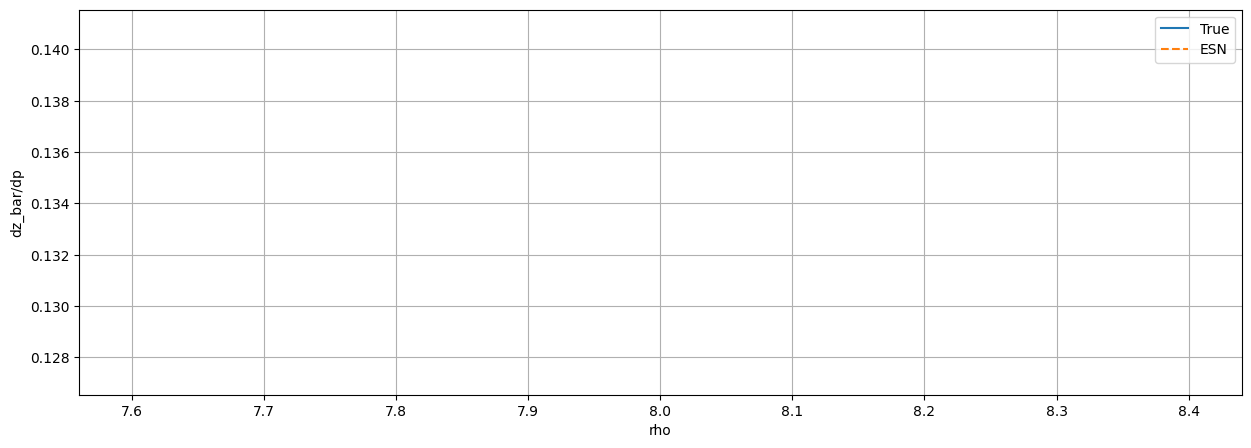

In [65]:
dJdp_true_mean = np.mean(dJdp["true"]["adjoint"], axis = 2)
dJdp_esn_mean =  np.mean(dJdp["esn"]["adjoint"], axis = 2)
plt.figure(figsize=(15,5))
for i, param in enumerate(param_vars):
    plt.subplot(1,len(param_vars),i+1)
    vis.plot_lines(p_list[:,eParam.p],
                dJdp_true_mean[:,eParam[param],0],
                dJdp_esn_mean[:,0,0], #dJdp_esn_mean[:,eParam[param],0],
                linestyle=["-","--"],
                xlabel="rho",
                ylabel=f"dz_bar/d{param}",
                )

    plt.legend(["True","ESN"])

In [68]:
dJdp_true_mean

array([[[0.14086427]]])

In [69]:
dJdp_esn_mean

array([[[0.12723019]]])

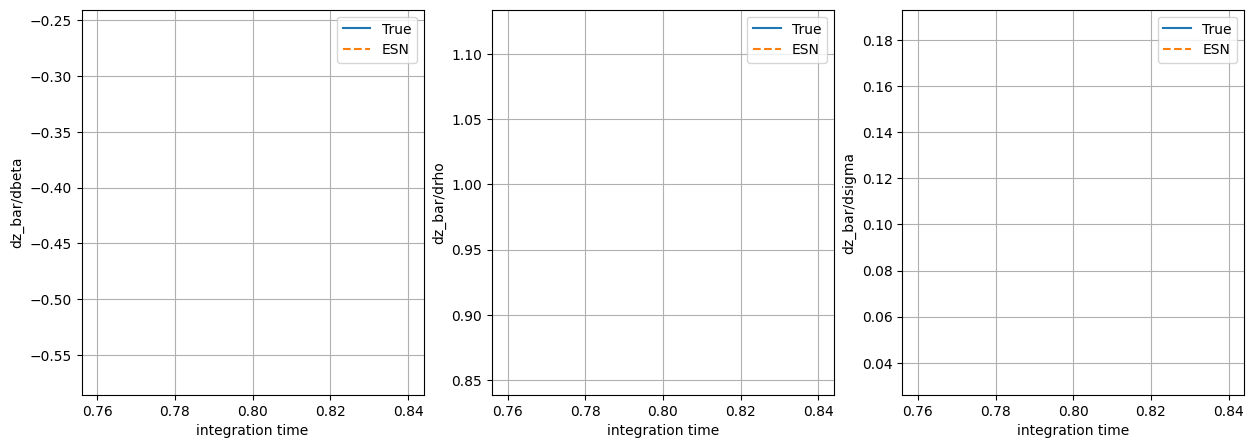

In [15]:
dJdp_true_mean = np.mean(dJdp["true"]["adjoint"], axis = 2)
dJdp_esn_mean = np.mean(dJdp["esn"]["adjoint"], axis = 2)
plt.figure(figsize=(15,5))
for i, param in enumerate(param_vars):
    plt.subplot(1,len(param_vars),i+1)
    vis.plot_lines(loop_time_arr,
                dJdp_true_mean[0,eParam[param],:],
                dJdp_esn_mean[0,eParam[param],:],
                linestyle=["-","--"],
                xlabel="integration time",
                ylabel=f"dz_bar/d{param}",
                )

    plt.legend(["True","ESN"])

beta = 2.667 rho = 28.000 sigma = 10.000


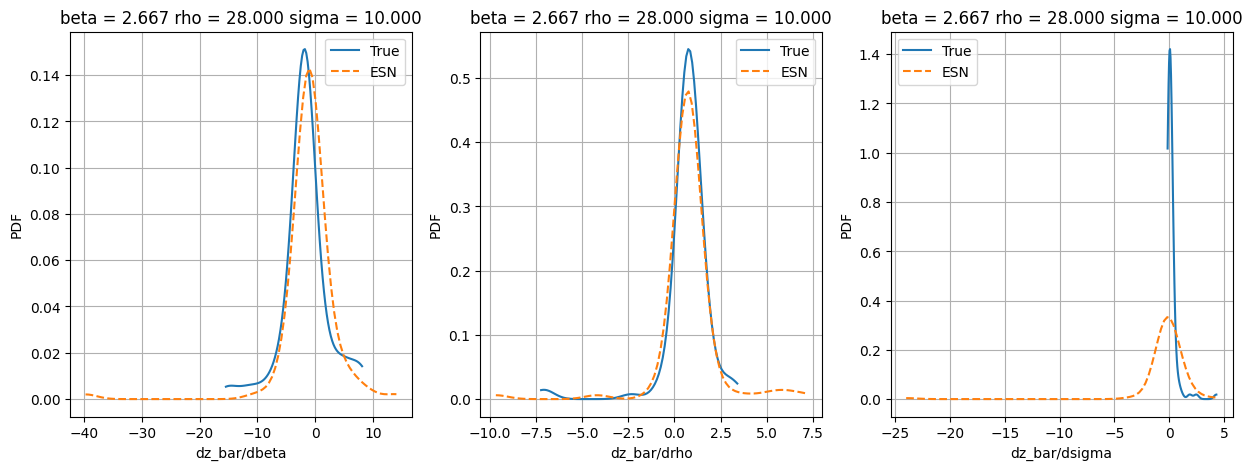

In [27]:
#pdf of the gradients
for p_idx, p in enumerate(p_list):
    plt.figure(figsize=(15,5))
    regime_str = ' '.join([f"{param.name} = {p[param]:0.3f}" for param in eParam])
    print(regime_str)
    for i, param in enumerate(param_vars):
        plt.subplot(1,len(param_vars),i+1)
        vis.plot_statistics(dJdp["true"]["adjoint"][p_idx,eParam[param],:,0],
                    dJdp["esn"]["adjoint"][p_idx,eParam[param],:,0], 
                    linestyle=["-","--"],
                    xlabel=f"dz_bar/d{param}",
                    ylabel="PDF",
                    )
        plt.title(regime_str)
        plt.legend(["True","ESN"])
        # plt.xlim([-2,2])

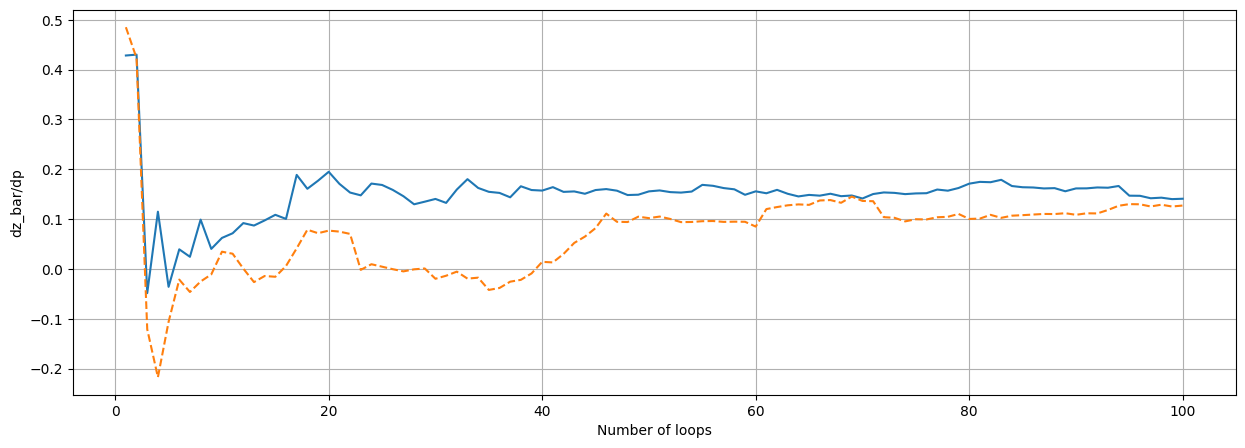

In [70]:
for p_idx, p in enumerate(p_list):
    plt.figure(figsize=(15,5))
    for i, param in enumerate(param_vars):
        cum_mean = 1/np.arange(1,n_loops+1) * np.cumsum(dJdp["true"]["adjoint"][p_idx,eParam[param],:,0])
        cum_mean_pred = 1/np.arange(1,n_loops+1) * np.cumsum(dJdp["esn"]["adjoint"][p_idx,eParam[param],:,0])
        plt.subplot(1,len(param_vars),i+1)
        plt.plot(np.arange(1,n_loops+1), cum_mean)
        plt.plot(np.arange(1,n_loops+1), cum_mean_pred, '--')
        plt.xlabel("Number of loops")
        plt.ylabel(f"dz_bar/d{param}")
        plt.grid()

In [51]:
# sens_results_list = ["20240115_223813","20240115_225852","20240116_003927","20240116_014254","20240116_233616"]
sens_results_list = ["20240116_014254","20240117_174305","20240117_160412"]
sens_results = pp.unpickle_file(
        experiment_path / f"sensitivity_results_20240116_233616.pickle"
    )[0]
sens_results

{'dJdp': {'true': {'adjoint': array([[[[-1.32219415],
            [-1.28739064],
            [-5.62029067],
            ...,
            [ 0.27989301],
            [-0.36219849],
            [-9.5879701 ]],
   
           [[ 1.08372913],
            [ 1.14789118],
            [ 0.71082812],
            ...,
            [ 0.09030241],
            [ 0.32960556],
            [ 8.09421192]],
   
           [[ 0.30859736],
            [ 0.22439682],
            [ 0.16822018],
            ...,
            [ 0.16539554],
            [ 0.23429702],
            [-0.88877354]]]])},
  'esn': {'adjoint': array([[[[[-0.30673184],
             [ 0.42149005],
             [-1.97622659],
             ...,
             [-4.11067687],
             [-7.25147349],
             [-0.6295794 ]],
   
            [[ 1.45530308],
             [ 1.01205694],
             [ 1.28048726],
             ...,
             [ 1.25214459],
             [ 1.98661317],
             [ 0.60965649]],
   
            [[ 0.1371

True: -1.261
ESN: -1.028
True: -1.214
ESN: -0.308
True: -1.281
ESN: -1.311


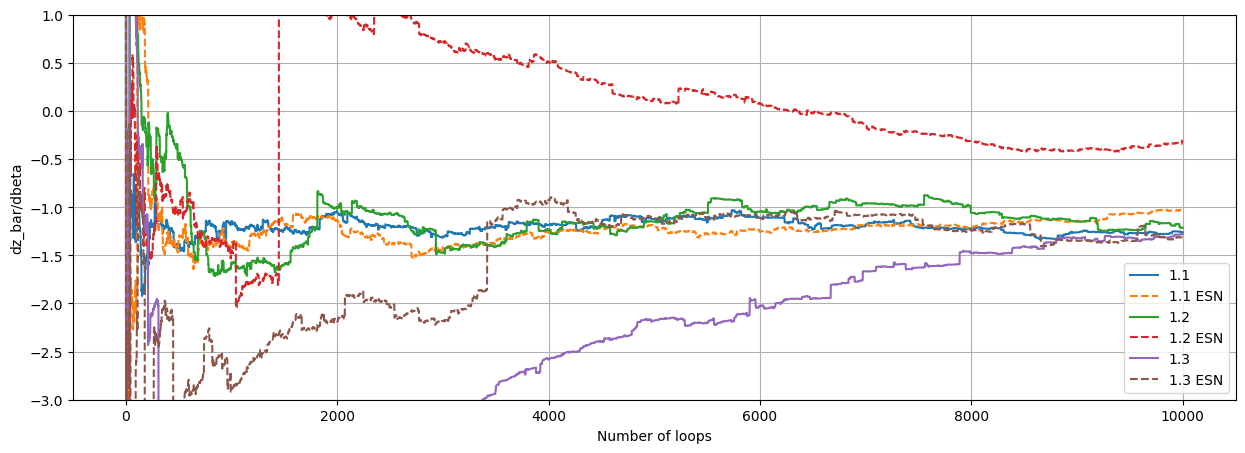

In [54]:
p_list = [[8/3, 28, 10]]
n_loops = 10000
esn_idx = 1
param = "beta"
for p_idx, p in enumerate(p_list):
    legend_str = []
    plt.figure(figsize=(15,5))
    for loop_time_idx in range(len(sens_results_list)):
        sens_results = pp.unpickle_file(
            experiment_path / f"sensitivity_results_{sens_results_list[loop_time_idx]}.pickle"
        )[0]
        # for i, param in enumerate(param_vars):
        dJdp_true = sens_results["dJdp"]["true"]["adjoint"][p_idx,eParam[param],:,0]
        cum_mean = 1/np.arange(1,n_loops+1) * np.cumsum(dJdp_true)
        # plt.subplot(1,len(param_vars),i+1)
        plt.plot(np.arange(1,n_loops+1), cum_mean)
        for esn_idx in range(1):
            dJdp_esn = sens_results["dJdp"]["esn"]["adjoint"][esn_idx,p_idx,eParam[param],:,0]
            cum_mean_pred = 1/np.arange(1,n_loops+1) * np.cumsum(dJdp_esn)
            plt.plot(np.arange(1,n_loops+1), cum_mean_pred, '--')
            plt.xlabel("Number of loops")
            plt.ylabel(f"dz_bar/d{param}")
        dJdp_true_mean = np.mean(dJdp_true)
        dJdp_esn_mean = np.mean(dJdp_esn)
        plt.legend(["True","ESN"])
        print(f'True: {dJdp_true_mean:0.3f}')
        print(f'ESN: {dJdp_esn_mean:0.3f}')    
        #     # plt.xlim([0,1000])

        #    
        legend_str.append(f"{sens_results['loop_times'][0]}")
        legend_str.append(f"{sens_results['loop_times'][0]} ESN")
    plt.grid(visible=True)
    plt.legend(legend_str)
    plt.ylim([-3,1])
plt.show()

beta = 2.667 rho = 28.000 sigma = 10.000
beta = 2.667 rho = 28.000 sigma = 10.000
beta = 2.667 rho = 28.000 sigma = 10.000
beta = 2.667 rho = 28.000 sigma = 10.000


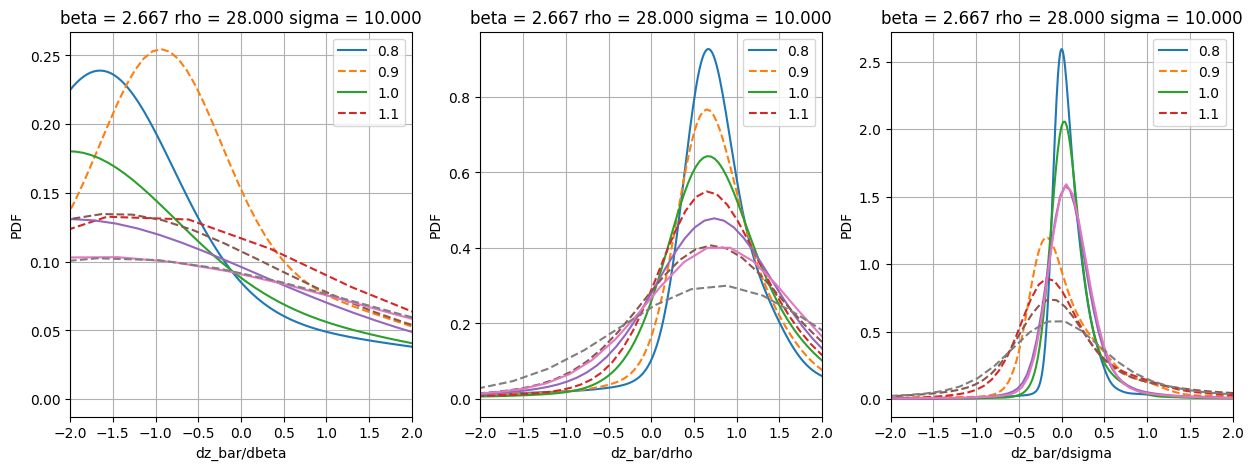

In [99]:
#pdf of the gradients
for p_idx, p in enumerate(p_list):
    plt.figure(figsize=(15,5))
    for loop_time_idx in range(4):
        sens_results = pp.unpickle_file(
            experiment_path / f"sensitivity_results_{sens_results_list[loop_time_idx]}.pickle"
        )[0]
        
        regime_str = ' '.join([f"{param.name} = {p[param]:0.3f}" for param in eParam])
        print(regime_str)
        for i, param in enumerate(param_vars):
            plt.subplot(1,len(param_vars),i+1)
            vis.plot_statistics(sens_results["dJdp"]["true"]["adjoint"][p_idx,eParam[param],:,0],
                        sens_results["dJdp"]["esn"]["adjoint"][0,p_idx,eParam[param],:,0], 
                        linestyle=["-","--"],
                        xlabel=f"dz_bar/d{param}",
                        ylabel="PDF",
                        n_bins=1000
                        )
            plt.title(regime_str)
            # plt.legend(["True","ESN"])
            plt.legend(["0.8","0.9","1.0","1.1"])
            plt.grid(visible=True)
            # plt.xscale("log")
            # plt.yscale("log")
            # plt.ylim([1e-4,1])
            plt.xlim([-2,2])
plt.show()

In [7]:
sens_results_list = ["20240115_223813","20240115_225852","20240116_003927","20240116_014254"]
sens_results = pp.unpickle_file(
            experiment_path / f"sensitivity_results_{sens_results_list[0]}.pickle"
        )[0]
yy = sens_results["dJdp"]["true"]["adjoint"][0,1,:,0]


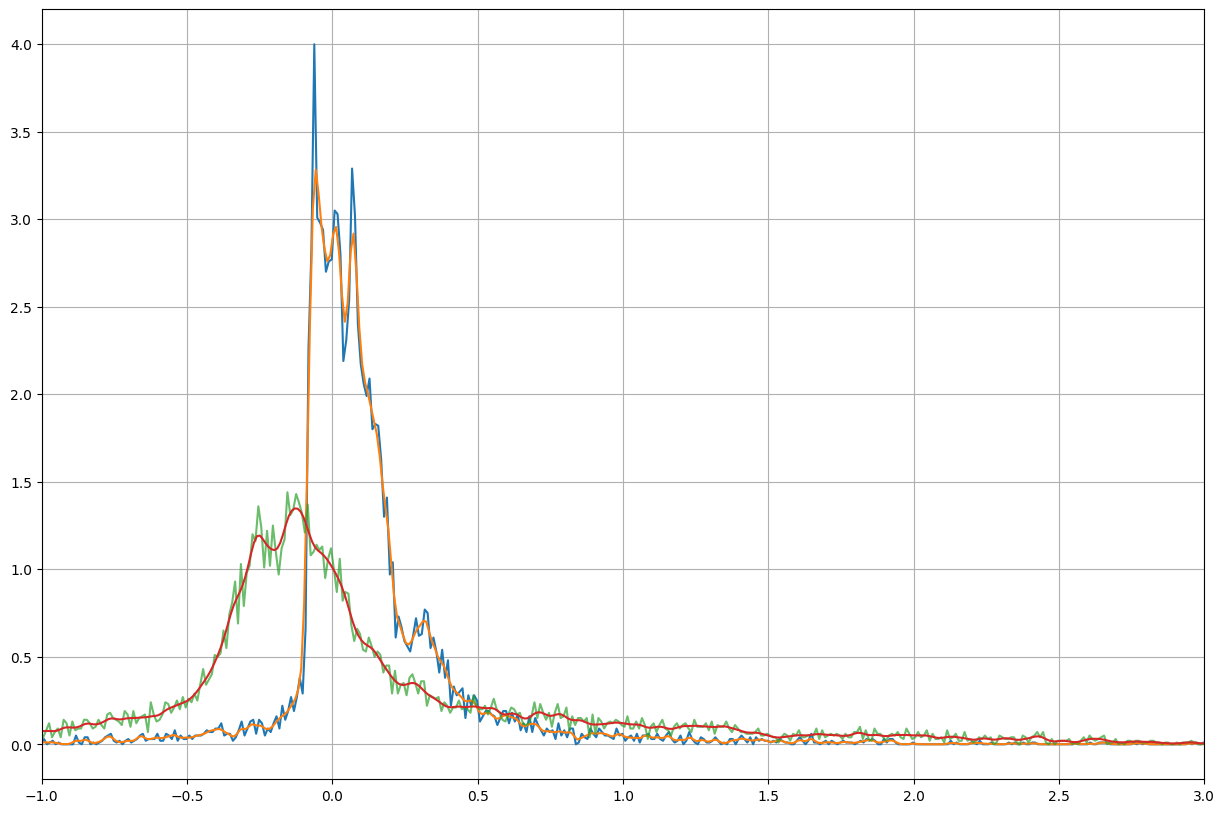

In [92]:
from scipy import signal, stats
n_bins = 1000
binwidth = 0.01
plt.figure(figsize=(15,10))
# for i in range(4):
sens_results = pp.unpickle_file(
        experiment_path / f"sensitivity_results_{sens_results_list[2]}.pickle"
    )[0]
yy = sens_results["dJdp"]["true"]["adjoint"][0,2,:,0]
yy_pred = sens_results["dJdp"]["esn"]["adjoint"][0,0,2,:,0]
density = stats.gaussian_kde(yy, bw_method=0.01)
n, x = np.histogram(yy, bins = np.arange(min(yy), max(yy) + binwidth, binwidth), density=True)
bin_centers = 0.5*(x[1:]+x[:-1])
plt.plot(bin_centers,n) ## using bin_centers rather than edges
plt.plot(x, density(x))

n, x = np.histogram(yy_pred, bins = np.arange(min(yy_pred), max(yy_pred) + binwidth, binwidth), density=True)
bin_centers = 0.5*(x[1:]+x[:-1])
density_pred = stats.gaussian_kde(yy_pred, bw_method=0.01)

plt.plot(bin_centers,n,alpha=0.7) ## using bin_centers rather than edges
plt.plot(x, density_pred(x))

# plt.xscale("log")
# plt.yscale("log")
plt.xlim([-1,3])
A = 0.4897
alpha = 1.865
x2 = np.arange(0.1,100.0,0.1)
yy2 = A * x2 ** -(1+ alpha)
# plt.plot(x2, yy2)
# plt.ylim([1e-2,2])
plt.grid()
plt.show()